In [1]:
import os
import numpy as np 
import pandas as pd
import arcpy
from arcpy import env

In [21]:
result_path = r"F:\cache_data\pre_soiltype_table\dy\autogluon\predict_csv\prediction_soiltype_tz_20240222.csv"

In [22]:
# 读取预测结果
data = pd.read_csv(result_path,index_col=False)

In [23]:
stander_path = r"D:\ArcGISProjects\workspace\shbyq\feature_raster_file\features_data_dy.gdb\DEM"

In [24]:
data.columns

Index(['prediction_0', 'prediction_1', 'prediction_2', 'prediction_3',
       'prediction_4', 'prediction_5', 'prediction_6', 'prediction_7',
       'prediction_8', 'prediction_9',
       ...
       'prediction_334', 'prediction_335', 'prediction_336', 'prediction_337',
       'prediction_338', 'prediction_339', 'prediction_340', 'prediction_341',
       'prediction_342', 'prediction_343'],
      dtype='object', length=344)

In [25]:
# 合并除第一列外的所有列到第一列
frames = []
for col in data.columns:
    frames.append(data[col])

# 合并 DataFrame
merged_data = pd.concat(frames, axis=0, ignore_index=True)

In [26]:
merged_data.dropna(inplace=True)

In [27]:
merged_data.size

171871183

In [28]:
merged_data.value_counts()

59.0    26504015
8.0     25652367
53.0    21082279
54.0    15570292
76.0    11507752
6.0      9820906
61.0     6608091
49.0     6220742
46.0     6210911
57.0     5266154
43.0     4101348
60.0     3256165
52.0     3050294
63.0     2986646
48.0     2696936
11.0     2477237
29.0     2341924
56.0     1936341
65.0     1868292
42.0     1767696
12.0     1679101
25.0     1253294
78.0     1137020
79.0      972994
50.0      831161
21.0      559096
75.0      540101
14.0      518324
74.0      422445
64.0      301013
45.0      291734
40.0      242840
28.0      238194
47.0      237502
27.0      228458
80.0      213848
9.0       194359
22.0      149822
15.0      144435
41.0      112484
26.0      107566
55.0       99486
82.0       99074
13.0       88044
1.0        71095
4.0        58616
20.0       38204
23.0       38072
35.0       29872
17.0       27402
24.0       19139
dtype: int64

In [20]:

# def label_array(mixed_array):
#     # 获取唯一的值
#     unique_values = list(set(merged_data.values))

#     # 创建一个字典来映射唯一值到标签
#     label_mapping = {value: index for index, value in enumerate(unique_values)}

#     # 使用字典映射函数将数组标签化
#     labeled_array = np.vectorize(label_mapping.get)(mixed_array)
#     return labeled_array,label_mapping
# # 标签化array
# cach_result = label_array(merged_data)

In [10]:
type(merged_data)

pandas.core.series.Series

In [29]:
dem_array = arcpy.RasterToNumPyArray(stander_path)
dem_array.shape

(12881, 13343)

In [30]:
dem_array.shape[0] * dem_array.shape[1]

171871183

In [31]:
raster_array = np.reshape(merged_data.values,dem_array.shape)

In [32]:
raster_array = raster_array.astype(np.float32)

In [33]:
dem_array.dtype,raster_array.dtype

(dtype('float32'), dtype('float32'))

In [34]:
env.workspace = r"D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_dy.gdb"
env.extent = stander_path

In [35]:
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster

In [36]:
# 按掩膜处理
result_raster = mask_raster(raster_array,stander_path, 5)
result_raster.save("prediction_sioltype_weight_20240222_tz")
print("完成")

完成


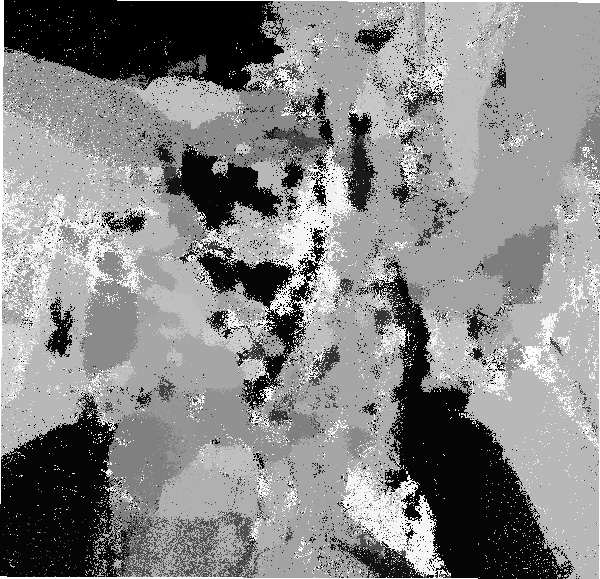

In [37]:
result_raster

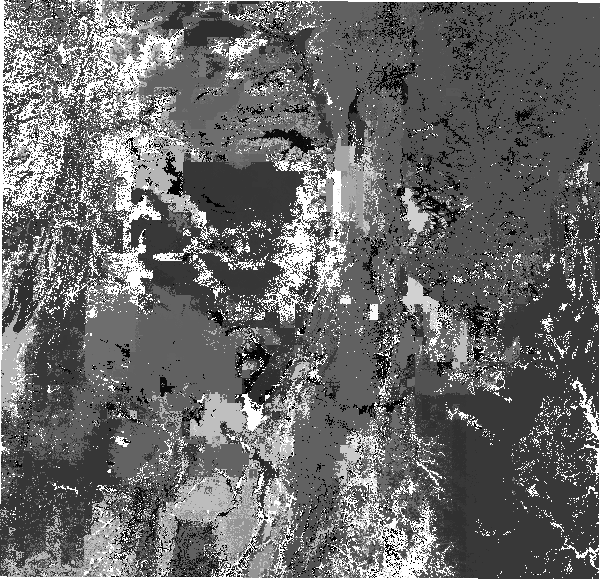

In [18]:
result_raster

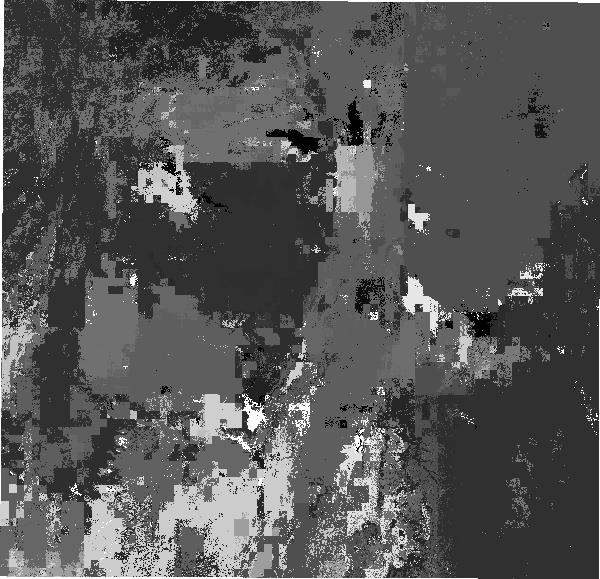

In [19]:
result_raster